# Setup Iowa for experiment with different initial conditions

In this case we will use the new model (604) with the $\Delta S$ obtained from GRACE

In [1]:
from ifis_tools import asynch_manager as am 
from ifis_tools import database_tools as db 
import pandas as pd 
import numpy as np 
from ipywidgets import FloatProgress
from IPython.display import display

Unable to import WMF, cant create basins whit it


In [2]:
path_out = 'C:/Users/nicolas/Desktop/'

---
## 1. Set up of a watershed to eentually run with Async
From the database creates an element of the "watershed" for Iowa that includes all the links, if **linkid != 0**, the watershed will be the upstream elements of that link.

In [3]:
cu = am.hlmModel(linkid=0, model_uid=604)

In [21]:
cu.Table.head(3)

,Acum,Area,Long
link_id,,,
298897,2.377302,0.051123,0.163
458960,0.452436,0.452436,0.679
555843,5787.299000,0.012554,0.163


**Table 1** : The initial table only contains the link_id, total area, hill area and link lenght. 

In [22]:
# Here the code sorts and writes the topology file for the watershed.
cu.write_rvr(path=path_out + 'topology.rvr')

In [24]:
cu.topo.head(3)

,id,link_id
0,24431,24854
1,24431,25385
2,24432,24431


**Table 2**: Topology table, this is the table that **ifis_tools** uses to write the **.rvr** file for ASYNCH.

---
## 2. Set up for model with $Ds$ and $k3$ from USGS data

Initial characteristics to setup the model soil depth and water depletion from the hills.

In [5]:
#Data with results from the analysis of the USGS stations
D = pd.read_csv('DeltaResults.csv')

#Depth of the soil and several initial conditions.
SoilDepth = np.percentile(D['DS'], 50)
initial = [1-SoilDepth*i for i in [0.001,0.2,0.4,0.6,0.8]]

#Speed at which the water goes out from the hill soils
k3 = 1 / (D['Days'] * 24*60)
k3 = np.percentile(k3, 50)

In [25]:
D.head(5)

,usgs_id,links,DS,Days,y,x
0,5483450,437890.0,0.335900,237.759169,42.759944,-93.621849
1,5476590,279554.0,0.621756,128.447861,41.778597,-94.492749
2,6898000,555741.0,0.220627,361.983503,43.126111,-94.705833
3,5457000,522692.0,0.232616,343.326562,43.637222,-92.974444
4,6808820,216755.0,0.290281,275.123400,40.687139,-95.600222


**Table 3:** This table contains the results of an analysis performed over the USGS streamflow records at Iowa, the variable **DS** contains the estimated $\Delta S$ and **Days** the number of days that each stations shows for water depletion in the hills.

**Params**: Creation of the params file for the model

In [31]:
f1 = FloatProgress(min =0, max = 4)
display(f1)

for factor in [30,60, 100, 150]:
    #Writes the param file 
    Params = {'runoff_c1': {'value': 0.0041,'format': '%.4f'},
        'runoff_e1': {'value': 1.67,'format': '%.2f'},
        'soil_c1': {'value': k3,'format': '%.3e'},
        'soil_c2': {'value': k3*factor,'format': '%.3e'},
        'infil1': {'value': 0.0067,'format': '%.4f'},
        'infil2': {'value': 2.0e-4,'format': '%.2e'},
        'TopDepth': {'value': 0.1,'format': '%.2f'},
        'StoIntercept': {'value': 1.0,'format': '%.2f'},
        'StoNoFlow': {'value': 1.0 - SoilDepth,'format': '%.3f'},
        'lambda1': {'value': 0.2,'format': '%.2f'},
        'lambda2': {'value': -0.1,'format': '%.2f'},
        'channel_vo': {'value': 0.33,'format': '%.2f'},}
    Order = ['runoff_c1','runoff_e1','soil_c1','soil_c2','infil1','infil2',
        'TopDepth', 'StoIntercept', 'StoNoFlow', 'lambda2', 'lambda1','channel_vo']
    cu.set_parameters(DictP=Params, DicOrder=Order)
    name = str(factor)
    cu.write_prm(path_out+'params_'+name+'.prm', 
        extraNames=Order,
        extraFormats=[Params[k]['format'] for k in Order])
    f1.value += 1

FloatProgress(value=0.0, max=4.0)

**Initial**: Setup of the initial conditions for the model, in this case we produce 5 different initial conditions all of them constant for the simulation region.

In [6]:
#Initial conditions
initial = [1-SoilDepth*i for i in [0.001,0.2,0.4,0.6,0.8]]
for c,init in enumerate(initial):
    path = 'initial_'+str(c)+'.uini'
    cu.write_initial(path_out+path, initial=[1e-06, 0.0001, 0.05, init, 1e-6, 1e-6, 1e-6])

**Global files**: Asynch requires global fils and run files, the global files contain the setup for the model run, while the run files (well, they do the run). 

In [30]:
#Initialize the dictionary that holds the process contained in the runfile.
year = 2016
Proc = {}
secondplane = True
consecutive = 4

#Iterate for the initial conditions
c2 = 0
for c,ini in enumerate(initial):
    
    #Iterate for the k3 factor
    for factor in [30,60, 100, 150]:

        #Run name 
        name = str(c) + '_' + str(factor)
        
        #Set the name of the global file
        global_name = 'Case_'+str(year)+'_'+name+'.gbl'
        #Writes the global file
        cu.write_Global(path_out + global_name,model_uid=604, 
            date1=str(year)+'-04-01 01:00', 
            date2=str(year)+'-12-30 01:00',
            rvrFile='topoFile.rvr', 
            rvrLink='',
            prmFile='params_'+str(factor)+'.prm',
            initialFile='initial_'+str(c)+'.uini',
            rainPath = '/Users/nicolas/BaseData/Rainfall/Binary/st4_'+str(year)+'/iowa_',
            controlFile='control.sav',
            nComponents = 4,
            Components = [0,3,4,5],
            datResults='Out_'+str(year)+name+'.dat', 
            evpFile='evap.mon')
        
        #Updates the dictionary with the parameters to setup the run
        if c == len(initial) or factor == 150:
            secondplane = False
        if c2 == consecutive:
            secondplane = False
            c2 = 0
        else:
            c2 += 1
            secondplane = True
        Proc.update({'Case_'+str(year)+'_'+name+'.gbl':{'nproc': 12, 'secondplane': secondplane}})
#Writes the runfile with all the comands
cu.write_runfile(path_out + 'runCase_'+str(year)+'.sh', Proc, jobName='soil_'+str(year))  

# Experiment of the hill outflow.

In [51]:
def HillWater(S, k3, k4, Si = 1.0, Sn = 0.750):
    if S < Si:
        return k3*(S-Sn)
    else:
        #Is = (k3 - k3*f)*bl
        Is = k3*(Si - Sn)
        return Is + k4*(S-Si)

In [27]:
%matplotlib inline 
import pylab as pl 

In [70]:

q = S.apply(HillWater, args= (k3v, k3v*20))

In [67]:
S2 = pd.Series(np.linspace(0.770+1.5,1.4+1.5,20))
q2 = S.apply(HillWater, args= (k3v,k3v*20))

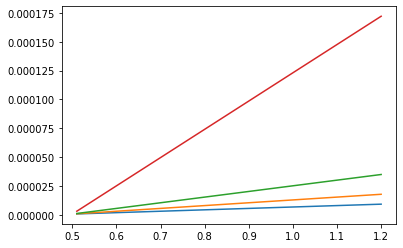

In [77]:
S = pd.Series(np.linspace(0.51, 1.2,20))
for f in [5,10,20,100]:
    q = S.apply(HillWater, args= (k3v, k3v*f, 0.5, 0.250))
    pl.plot(S, q)moduel 
#pl.plot(S2, q2)